In [1]:
import heapq
import random

import mglearn as mglearn
import notebook.jstest
import np as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn_evaluation
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVC

!pip install numpy scipy scikit-learn matplotlib pandas
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import PCA

import heapq

You should consider upgrading via the '/Users/engineer/workspace/cse590-machine-learning/venv/bin/python -m pip install --upgrade pip' command.


In [175]:
X_train = pd.read_csv("./dataset/X_train.csv").values
y_train = pd.read_csv("./dataset/y_train.csv").values.ravel()
X_test = pd.read_csv("./dataset/X_test.csv").values
y_test = pd.read_csv("./dataset/y_test.csv").values.ravel()

scaler_standard = StandardScaler().fit(X_train)
X_train_standard = scaler_standard.transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

scaler_robust = RobustScaler().fit(X_train)
X_train_robust = scaler_robust.transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

scaler_minmax = MinMaxScaler().fit(X_train)
X_train_minmax = scaler_minmax.transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)


784

In [172]:
mlp = MLPClassifier(hidden_layer_sizes=256)
mlp.fit(X_train_standard, y_train)
mlp_predict_proba = mlp.predict_proba(X_test_standard)
print(len(mlp_predict_proba))


4999


In [173]:
svm = SVC(kernel='poly', C=10, degree=3, probability=True)
svm.fit(X_train_minmax, y_train)
svm_predict_proba = svm.predict_proba(X_test_minmax)
print(len(svm_predict_proba))


4999


In [176]:
svm_predictions = svm.predict(X_test_standard)
mlp_predictions = mlp.predict(X_test_minmax)

pred_proba_class_0_svm = svm_predict_proba[:, 0]
pred_proba_class_1_svm = svm_predict_proba[:, 1]
pred_proba_class_2_svm = svm_predict_proba[:, 2]
pred_proba_class_3_svm = svm_predict_proba[:, 3]
pred_proba_class_4_svm = svm_predict_proba[:, 4]

pred_proba_class_0_mlp = mlp_predict_proba[:, 0]
pred_proba_class_1_mlp = mlp_predict_proba[:, 1]
pred_proba_class_2_mlp = mlp_predict_proba[:, 2]
pred_proba_class_3_mlp = mlp_predict_proba[:, 3]
pred_proba_class_4_mlp = mlp_predict_proba[:, 4]

In [82]:
print(mlp_predict_proba[0])
print(mlp_predict_proba[1])
print(mlp_predict_proba[4998])

print(type(mlp_predict_proba))

[9.99898618e-01 7.53150988e-05 1.27823787e-06 2.47859314e-05
 2.88439511e-09]
[1.00000000e+00 1.52682653e-13 3.69123696e-11 1.44272817e-10
 2.48829521e-13]
[4.12566979e-12 8.46277786e-09 1.02614001e-01 1.55710178e-09
 8.97385989e-01]
<class 'numpy.ndarray'>


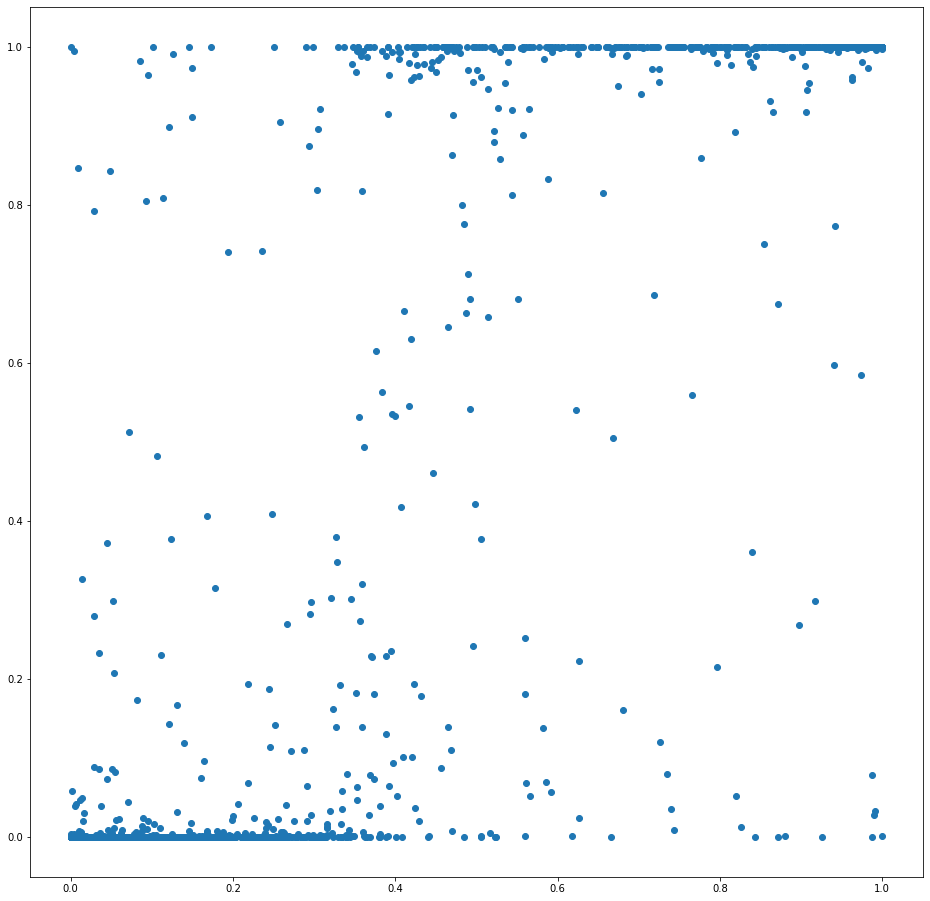

In [112]:
fig, ax = plt.subplots()
fig.set_figheight(16)
fig.set_figwidth(16)
plt.scatter(pred_proba_class_0_svm, pred_proba_class_0_mlp)

In [31]:
# get the class probabilities
# where those probabilities over 50% correctly classified? like what if the 90% predictions where incorrect
# run a test to see how many that is before you try to graph it
corrects = 0
guesses = 0
for i in range(4999):
    x = pred_proba_class_0_svm[i]
    y = y_test[i]
    if x > 0.50:
        guesses += 1
        if y == 0:
            corrects += 1

print(corrects)
print(guesses)
print(corrects / guesses)

844
893
0.9451287793952967


In [33]:
class_1_good_svm_bad_mlp = []
for i in range(4999):
    if pred_proba_class_0_svm[i] >= 0.8 and pred_proba_class_0_mlp[i] <= 0.2:
        class_1_good_svm_bad_mlp.append(i)

print(len(class_1_good_svm_bad_mlp))

11


In [35]:
class_1_good_mlp_bad_svm = []
for i in range(4999):
    if pred_proba_class_0_mlp[i] >= 0.8 and pred_proba_class_0_svm[i] <= 0.2:
        class_1_good_mlp_bad_svm.append(i)

print(len(class_1_good_mlp_bad_svm))

15


In [178]:
def extract_easy_vs_hard_for_plot(good_list, bad_list, x, y):
    desired_bucket = []
    for i in reversed(range(len(good_list))):
        if good_list[i] >= 0.8 and bad_list[i] <= 0.2:
            desired_bucket.append([x[i], y[i]])
            good_list.pop(i)
            bad_list.pop(i)

    return np.array(desired_bucket), good_list, bad_list


def extract_easy_vs_hard(easy_list, hard_list):
    match_easy = []
    match_hard = []
    for i in reversed(range(len(easy_list))):
        if easy_list[i] >= 0.8 and hard_list[i] <= 0.2:
            match_easy.append(i)
            match_hard.append(i)

    return match_easy, match_hard


def separate_and_graph_prediction_comparison(
        title_class,
        pred_proba_class_svm,
        pred_proba_class_mlp
):
    copy_pred_proba_svm = list(pred_proba_class_svm)
    copy_pred_proba_mlp = list(pred_proba_class_mlp)

    easy_svm_xy, copy_pred_proba_svm, copy_pred_proba_mlp = extract_easy_vs_hard_for_plot(
        copy_pred_proba_svm,
        copy_pred_proba_mlp,
        copy_pred_proba_svm,
        copy_pred_proba_mlp,
    )

    easy_mlp_xy, copy_pred_proba_mlp, copy_pred_proba_svm = extract_easy_vs_hard_for_plot(
        copy_pred_proba_mlp,
        copy_pred_proba_svm,
        copy_pred_proba_svm,
        copy_pred_proba_mlp,
    )

    plot_easy_hard(
        title_class,
        easy_svm_xy=easy_svm_xy,
        easy_mlp_xy=easy_mlp_xy,
        remaining_svm=copy_pred_proba_svm,
        remaining_mlp=copy_pred_proba_mlp
    )


def plot_easy_hard(title_class, easy_svm_xy, easy_mlp_xy, remaining_svm, remaining_mlp):
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.set_facecolor('black')

    plt.title(f'Prediction Comparisons for {title_class}')
    plt.xlabel('SVM Predictions')
    plt.ylabel('MLP Predictions')
    plt.scatter(easy_svm_xy[:, 0], easy_svm_xy[:, 1], c='lime', label='East SVM/Hard MLP')
    plt.scatter(easy_mlp_xy[:, 0], easy_mlp_xy[:, 1], c='c', label='East MLP/Hard SVM')
    plt.scatter(remaining_svm, remaining_mlp, c='m')
    plt.legend()


def agreements_good(pred_proba_svm, pred_proba_mlp):
    agree = 0
    for i in range(len(pred_proba_svm)):
        if pred_proba_svm[i] >= 0.8 and pred_proba_mlp[i] >= 0.8:
            agree += 1
    return agree


def agreements_bad(pred_proba_svm, pred_proba_mlp):
    agree = 0
    for i in range(len(pred_proba_svm)):
        if pred_proba_svm[i] <= 0.2 and pred_proba_mlp[i] <= 0.2:
            agree += 1
    return agree


def agreement_percentage(pred_proba_svm, pred_proba_mlp):
    agree_good = agreements_good(pred_proba_svm, pred_proba_mlp)
    agree_bad = agreements_bad(pred_proba_svm, pred_proba_mlp)

    return (agree_good + agree_bad) / len(pred_proba_svm) * 100

# 0: T-shirt/top
# 1: Trouser
# 2: Pullover
# 3: Dress
# 4: Coat

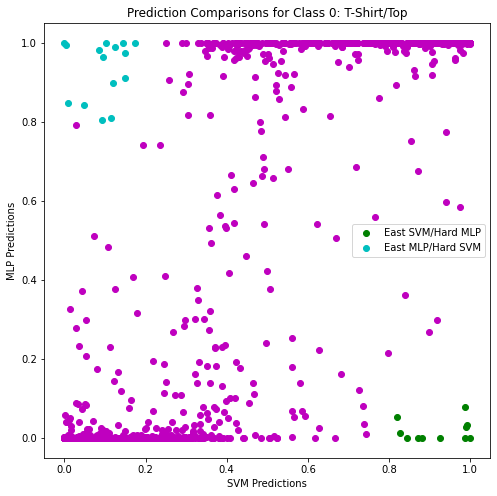

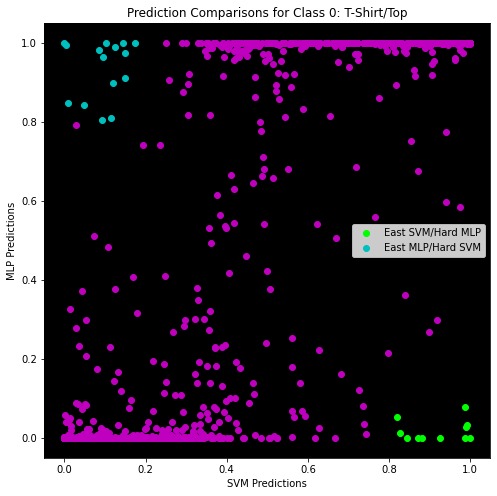

In [123]:
separate_and_graph_prediction_comparison(
    'Class 0: T-Shirt/Top',
    pred_proba_class_svm=pred_proba_class_0_svm,
    pred_proba_class_mlp=pred_proba_class_0_mlp
)

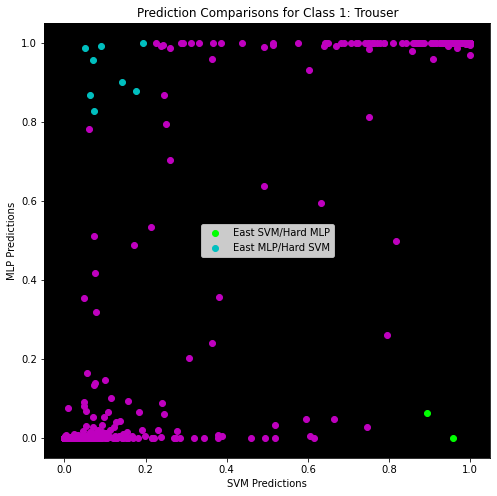

In [124]:
separate_and_graph_prediction_comparison(
    'Class 1: Trouser',
    pred_proba_class_svm=pred_proba_class_1_svm,
    pred_proba_class_mlp=pred_proba_class_1_mlp
)

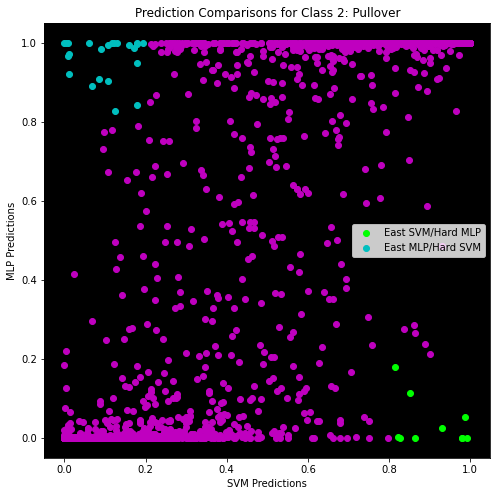

In [128]:
separate_and_graph_prediction_comparison(
    'Class 2: Pullover',
    pred_proba_class_svm=pred_proba_class_2_svm,
    pred_proba_class_mlp=pred_proba_class_2_mlp
)

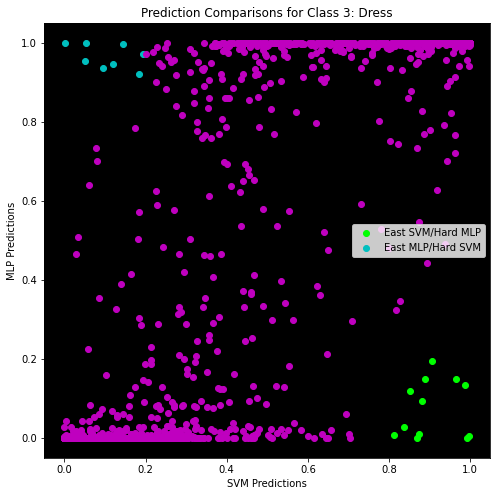

In [129]:
separate_and_graph_prediction_comparison(
    'Class 3: Dress',
    pred_proba_class_svm=pred_proba_class_3_svm,
    pred_proba_class_mlp=pred_proba_class_3_mlp
)

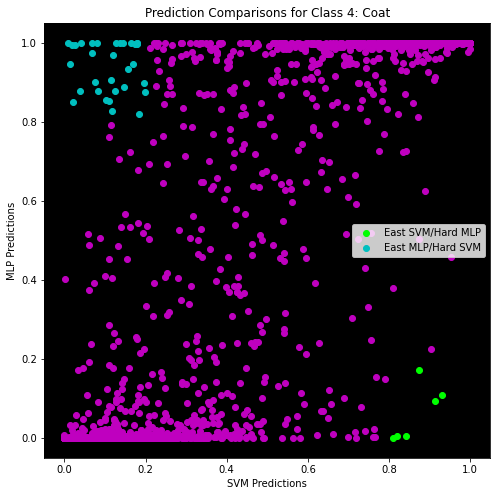

In [130]:
separate_and_graph_prediction_comparison(
    'Class 4: Coat',
    pred_proba_class_svm=pred_proba_class_4_svm,
    pred_proba_class_mlp=pred_proba_class_4_mlp
)

In [140]:
print(f'Class 0: {agreement_percentage(pred_proba_class_0_svm, pred_proba_class_0_mlp)}')
print(f'Class 1: {agreement_percentage(pred_proba_class_1_svm, pred_proba_class_1_mlp)}')
print(f'Class 2: {agreement_percentage(pred_proba_class_2_svm, pred_proba_class_2_mlp)}')
print(f'Class 3: {agreement_percentage(pred_proba_class_3_svm, pred_proba_class_3_mlp)}')
print(f'Class 4: {agreement_percentage(pred_proba_class_4_svm, pred_proba_class_4_mlp)}')

Class 0: 87.89757951590317
Class 1: 98.13962792558512
Class 2: 81.69633926785357
Class 3: 86.97739547909582
Class 4: 84.0368073614723


# Displaying

In [194]:
def display_item_in_28x28(plt, item_to_display_1d, expected_result, actual_result):
    misclassified_image = item_to_display_1d.reshape(28, 28)
    _, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
    axes.set_axis_off()
    axes.imshow(
        misclassified_image,
        cmap=plt.cm.gray_r,
        interpolation="nearest",
    )
    axes.set_title(f"Expected: {expected_result}\nActual: {actual_result}")



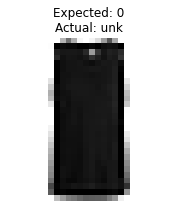

In [147]:
# 0: T-shirt/top
# 1: Trouser
# 2: Pullover
# 3: Dress
# 4: Coat
display_item_in_28x28(plt, X_test[0], y_test[0], 'unk')

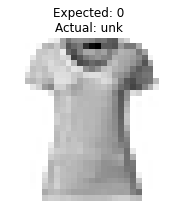

In [165]:
from random import randrange

randint = randrange(4999)
display_item_in_28x28(plt, X_test[randint], y_test[randint], 'unk')

In [180]:
c0_easy_svm, c0_hard_mlp = extract_easy_vs_hard(pred_proba_class_0_svm, pred_proba_class_0_mlp)
print(len(c0_easy_svm))


10


In [ ]:
for item in c0_easy_svm:
    display_item_in_28x28(plt, X_test[item], y_test[item], svm_predictions[item])


In [192]:
for item in c0_hard_mlp:
    display_item_in_28x28(plt, X_test[item], y_test[item], mlp_predictions[item])


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_axis_off'

In [196]:
c1_easy_svm, c1_hard_mlp = extract_easy_vs_hard(pred_proba_class_1_svm, pred_proba_class_1_mlp)
print(len(c1_easy_svm))

2


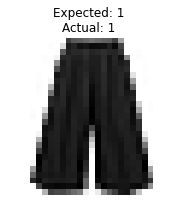

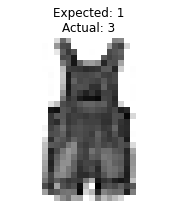

In [197]:
for item in c1_easy_svm:
    display_item_in_28x28(plt, X_test[item], y_test[item], svm_predictions[item])

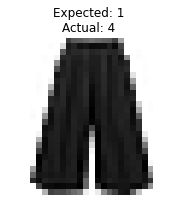

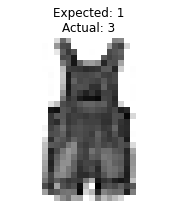

In [198]:
for item in c1_hard_mlp:
    display_item_in_28x28(plt, X_test[item], y_test[item], mlp_predictions[item])

In [203]:
print(c1_hard_mlp[0])

1956


In [205]:
mlp_predict_proba[1956]


array([1.03553785e-12, 1.22911957e-01, 2.48013547e-08, 2.26285130e-11,
       8.77088018e-01])

In [207]:
c4_easy_mlp, c4_hard_svm = extract_easy_vs_hard(pred_proba_class_4_mlp, pred_proba_class_4_svm)
print(len(c4_easy_mlp))


28


In [ ]:
for item in c4_easy_mlp:
    display_item_in_28x28(plt, X_test[item], y_test[item], mlp_predictions[item])

In [ ]:
for item in c4_hard_svm:
    display_item_in_28x28(plt, X_test[item], y_test[item], svm_predictions[item])


In [258]:
hard_both = []

for i in range(len(pred_proba_class_2_svm)):
    if 0.25 <= pred_proba_class_2_svm[i] <= 0.75 and 0.25 <= pred_proba_class_2_mlp[i] <= 0.75:
        hard_both.append(i)

print(hard_both)

[1943, 2019, 2054, 2059, 2074, 2107, 2126, 2147, 2176, 2185, 2208, 2221, 2248, 2278, 2298, 2328, 2357, 2398, 2414, 2423, 2486, 2496, 2504, 2507, 2529, 2550, 2558, 2569, 2572, 2597, 2612, 2621, 2665, 2734, 2766, 2835, 2892, 2897, 2902, 2934, 2946, 2965, 2971, 3769, 4005, 4060, 4090, 4118, 4182, 4223, 4240, 4272, 4287, 4298, 4435, 4446, 4484, 4495, 4519, 4525, 4540, 4576, 4595, 4684, 4710, 4824, 4934, 4942, 4951]


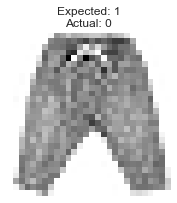

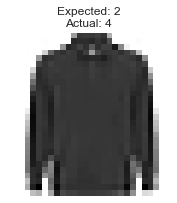

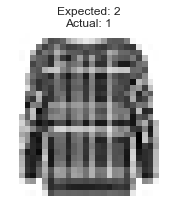

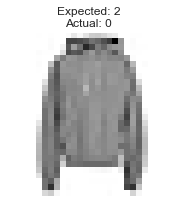

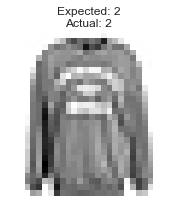

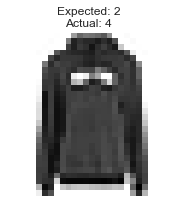

In [261]:
display_item_in_28x28(plt, X_test[hard_both[0]], y_test[hard_both[0]], svm_predictions[hard_both[0]])

for item in hard_both[5:10]:
    display_item_in_28x28(plt, X_test[item], y_test[item], svm_predictions[item])


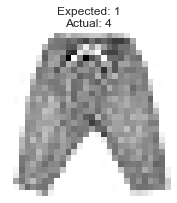

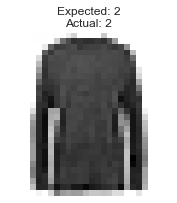

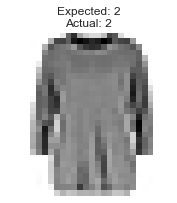

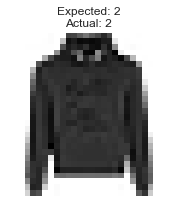

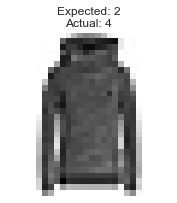

In [259]:

for item in hard_both[:5]:
    display_item_in_28x28(plt, X_test[item], y_test[item], mlp_predictions[item])


# Feature Importance

[1943, 2019, 2054, 2059, 2074, 2107, 2126, 2147, 2176, 2185, 2208, 2221, 2248, 2278, 2298, 2328, 2357, 2398, 2414, 2423, 2486, 2496, 2504, 2507, 2529, 2550, 2558, 2569, 2572, 2597, 2612, 2621, 2665, 2734, 2766, 2835, 2892, 2897, 2902, 2934, 2946, 2965, 2971, 3769, 4005, 4060, 4090, 4118, 4182, 4223, 4240, 4272, 4287, 4298, 4435, 4446, 4484, 4495, 4519, 4525, 4540, 4576, 4595, 4684, 4710, 4824, 4934, 4942, 4951]


In [202]:
mlp_predictions[1392]

3

In [209]:

def preprocess_data(X_scaled):
    pca = PCA(n_components=2)
    pca.fit(X_scaled)

    return pca.fit_transform(X_scaled)


def display_preprocessed_2d(pca_data):
    plt.figure(figsize=(32, 32))
    mglearn.discrete_scatter(pca_data[:, 0], pca_data[:, 1], y_train)
    plt.legend(
        [
            '0: T-shirt/top',
            '1: Trouser',
            '2: Pullover',
            '3: Dress',
            '4: Coat,',
        ],
        loc="best"
    )
    plt.gca().set_aspect("equal")
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")

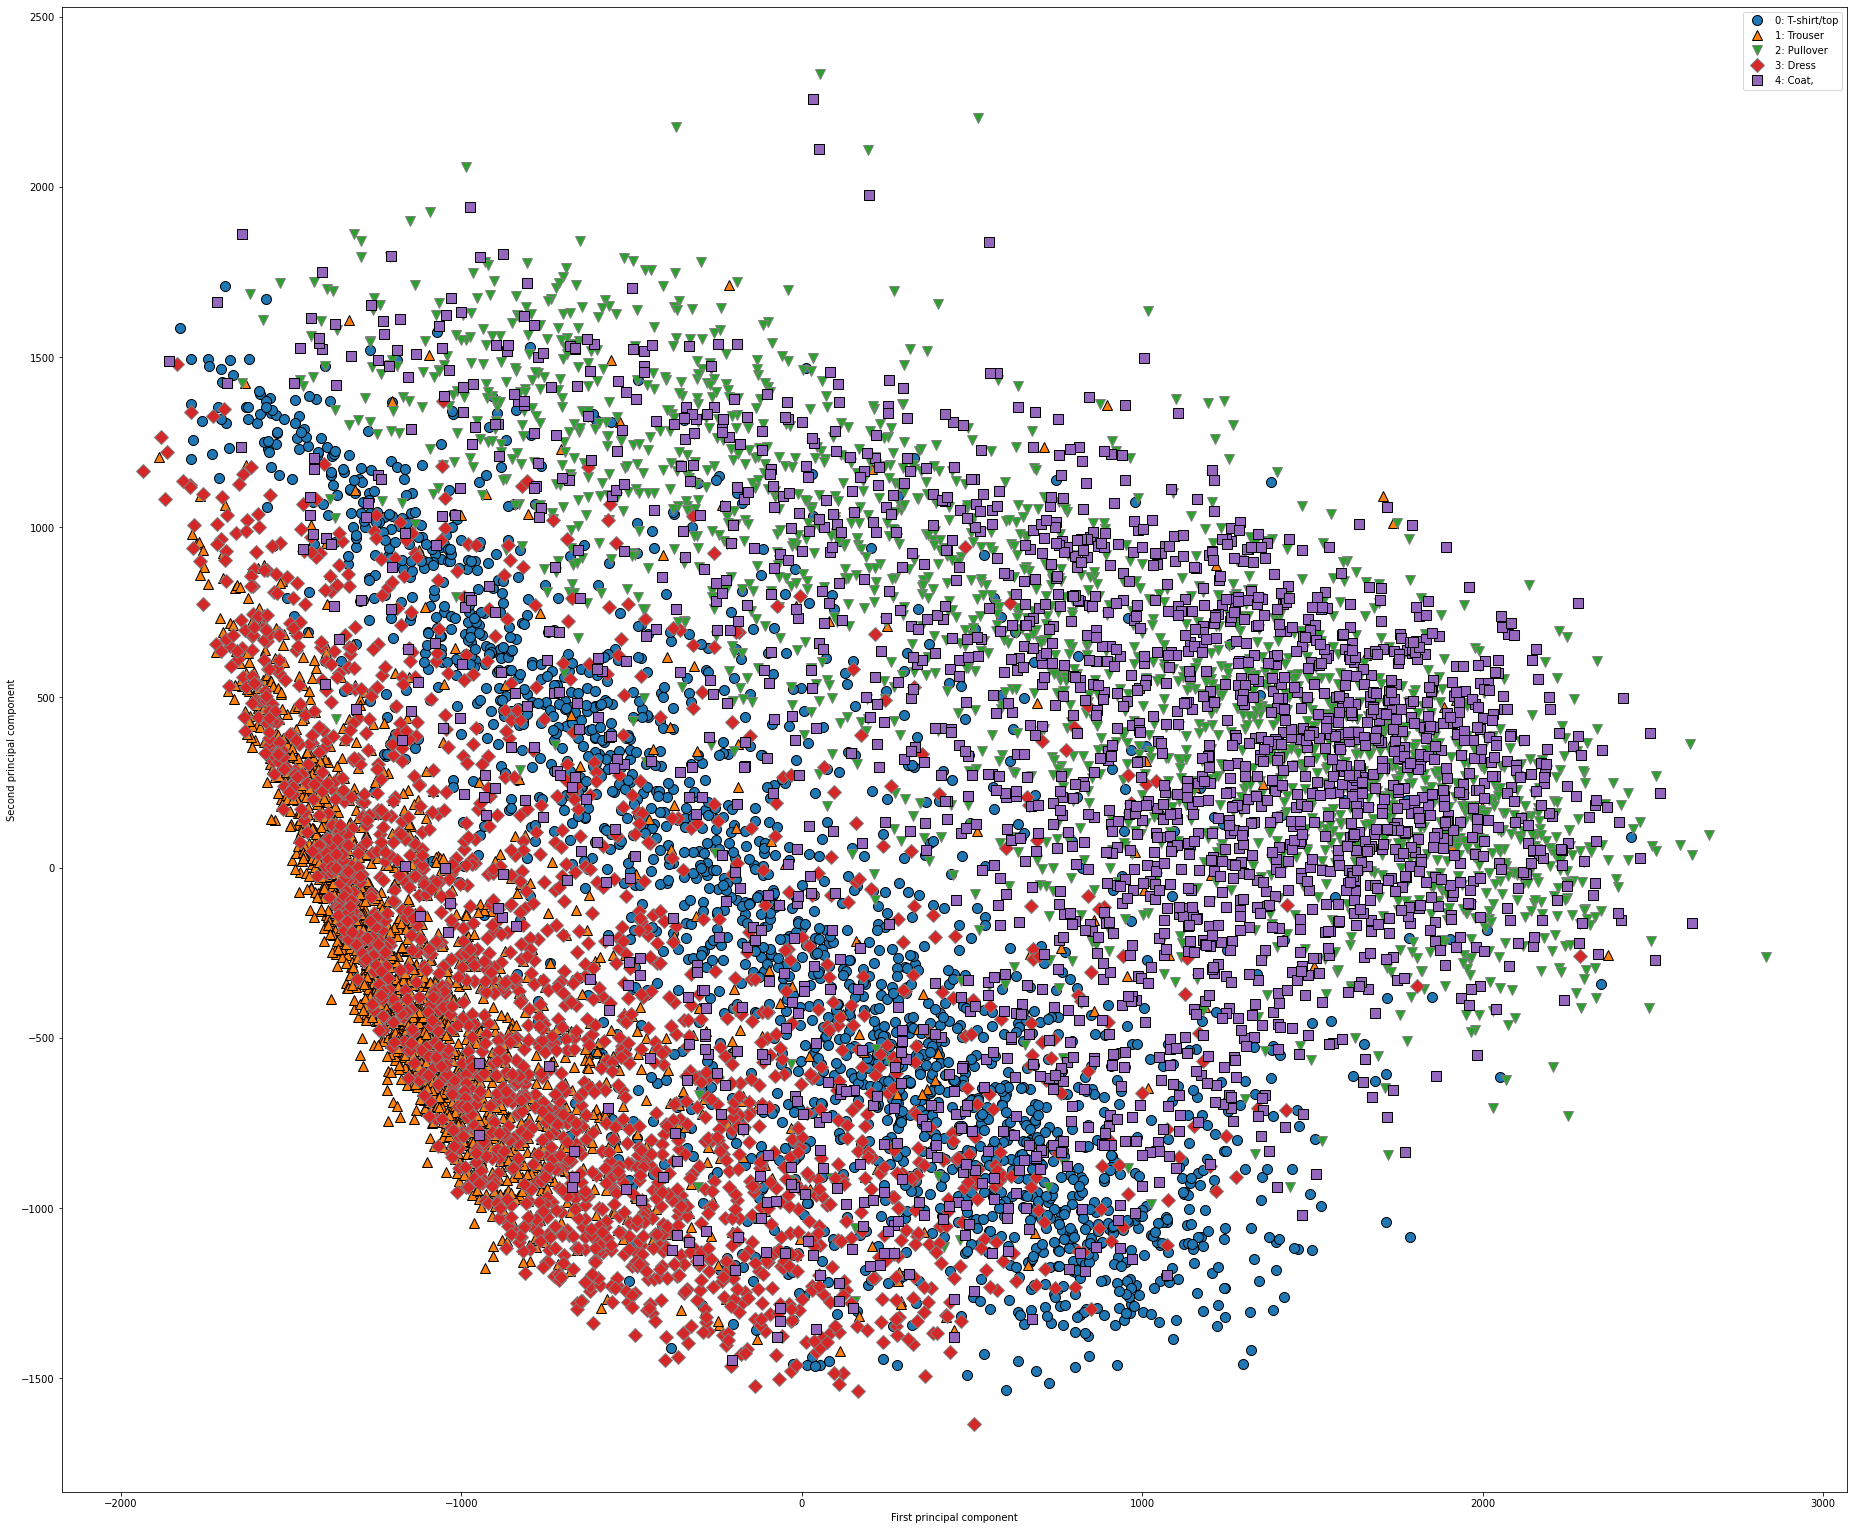

In [210]:
display_preprocessed_2d(preprocess_data(X_train))


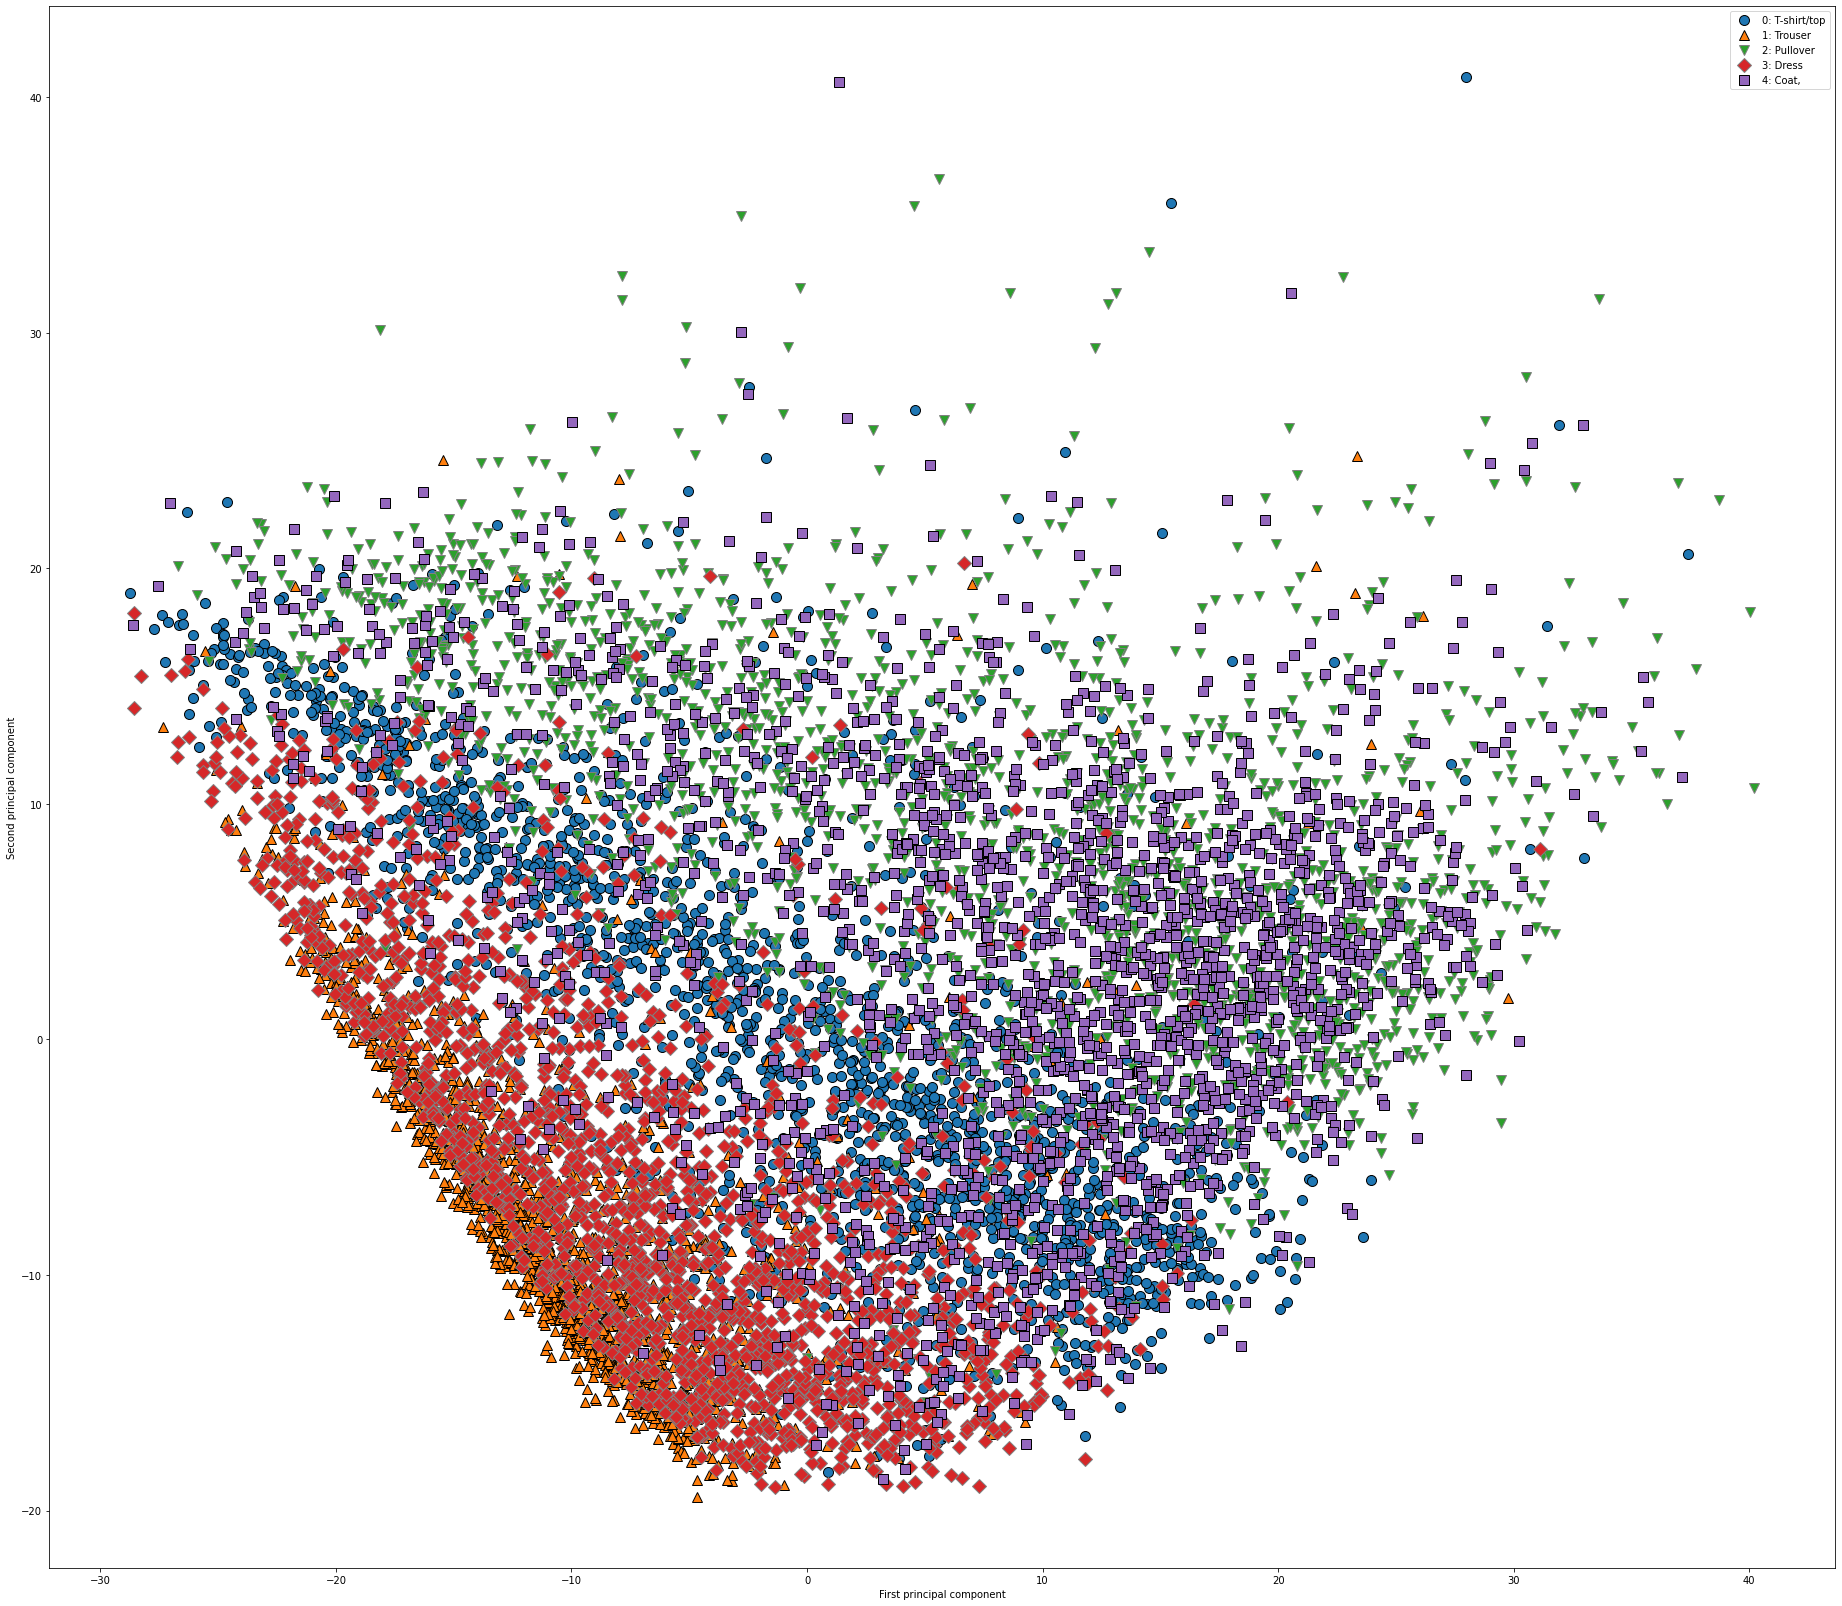

In [211]:
display_preprocessed_2d(preprocess_data(X_train_standard))


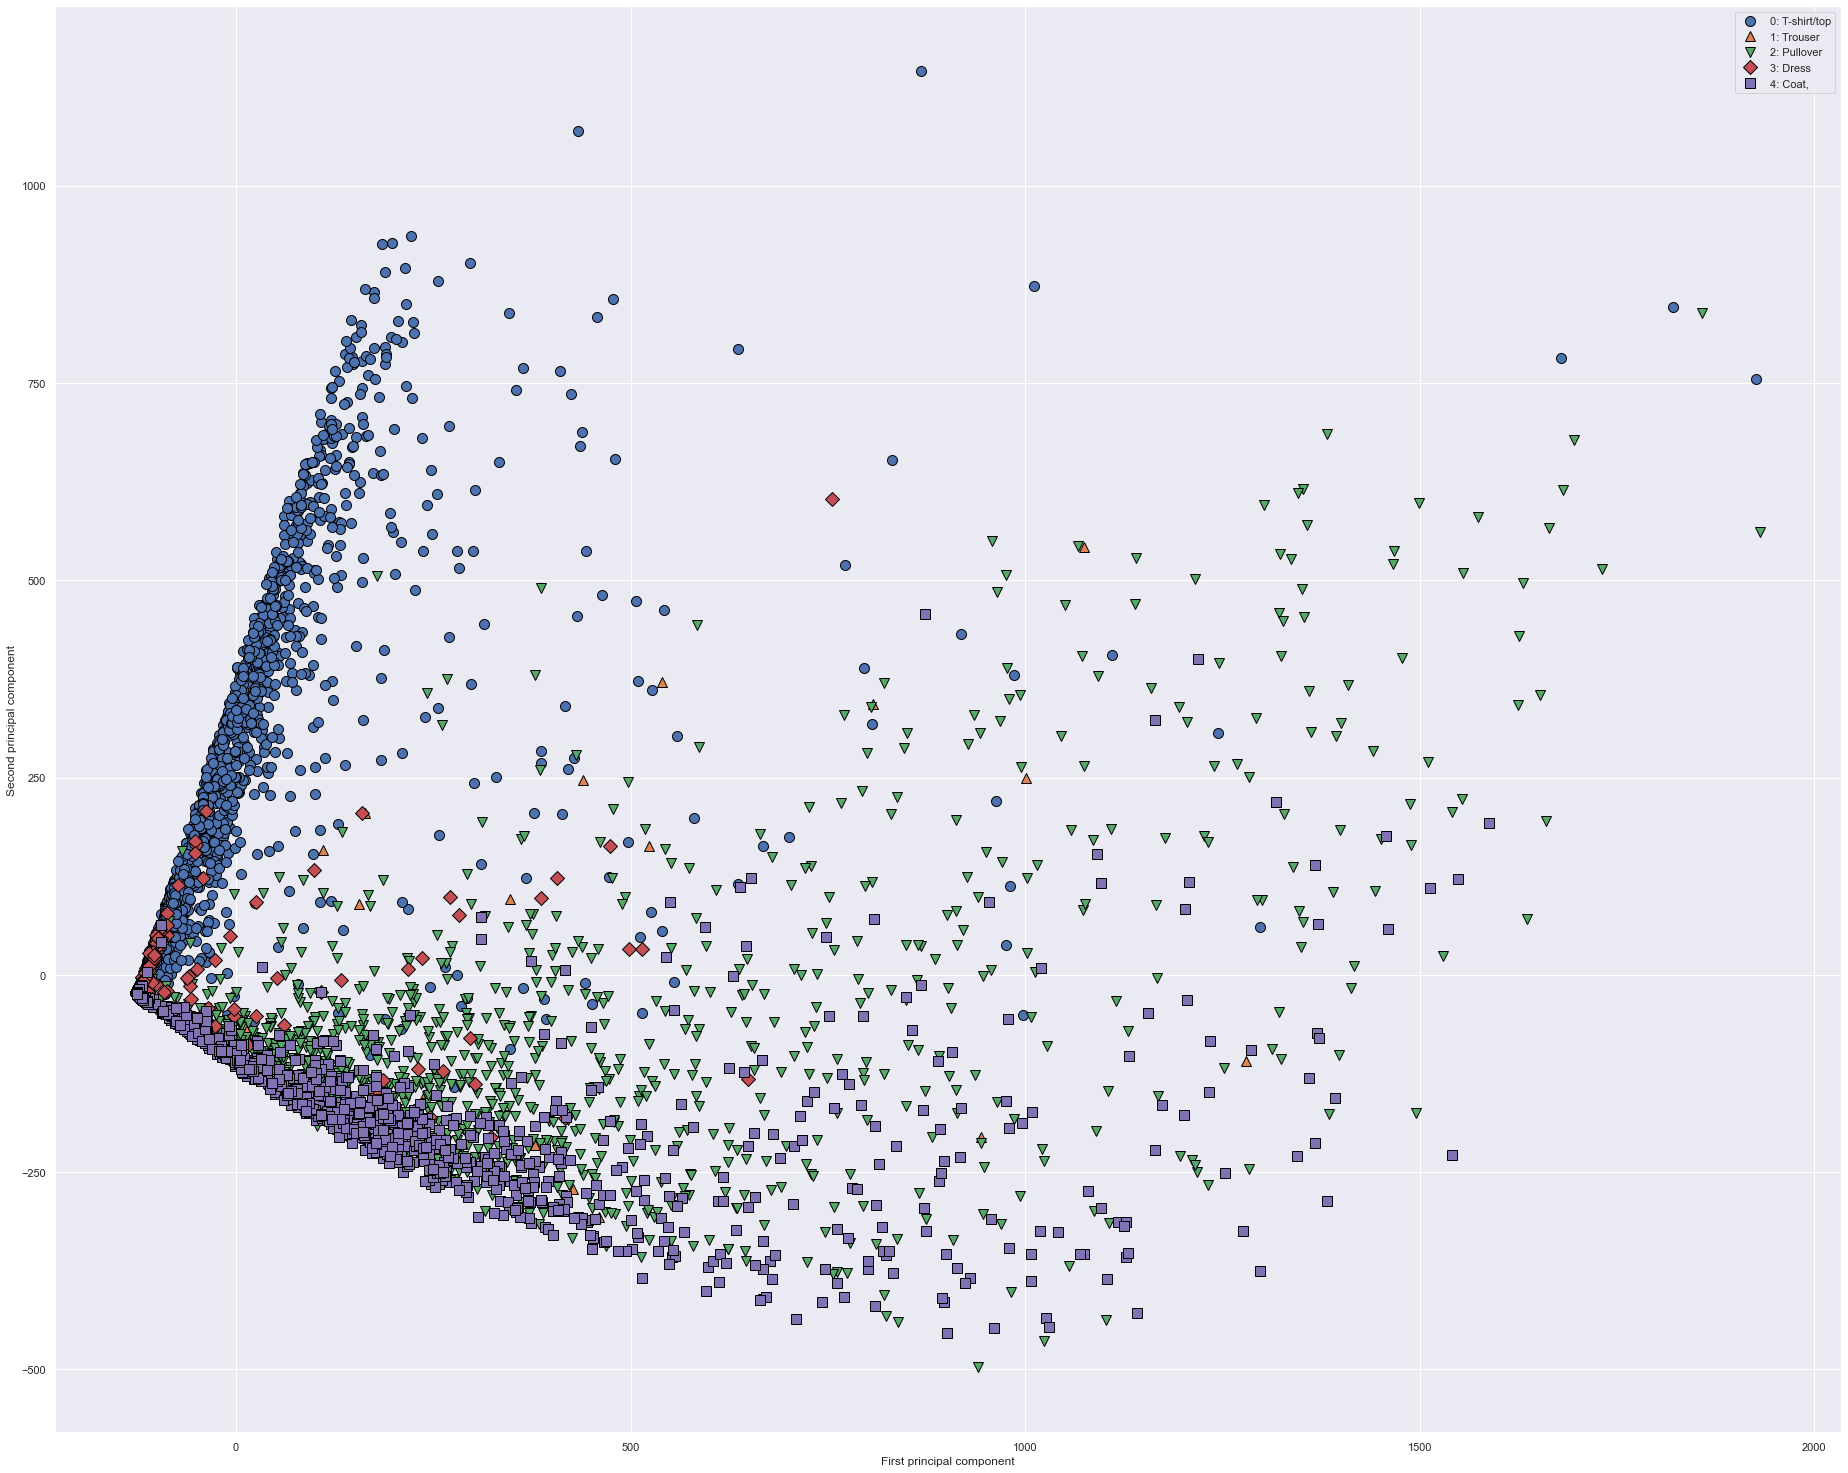

In [254]:
display_preprocessed_2d(preprocess_data(X_train_robust))

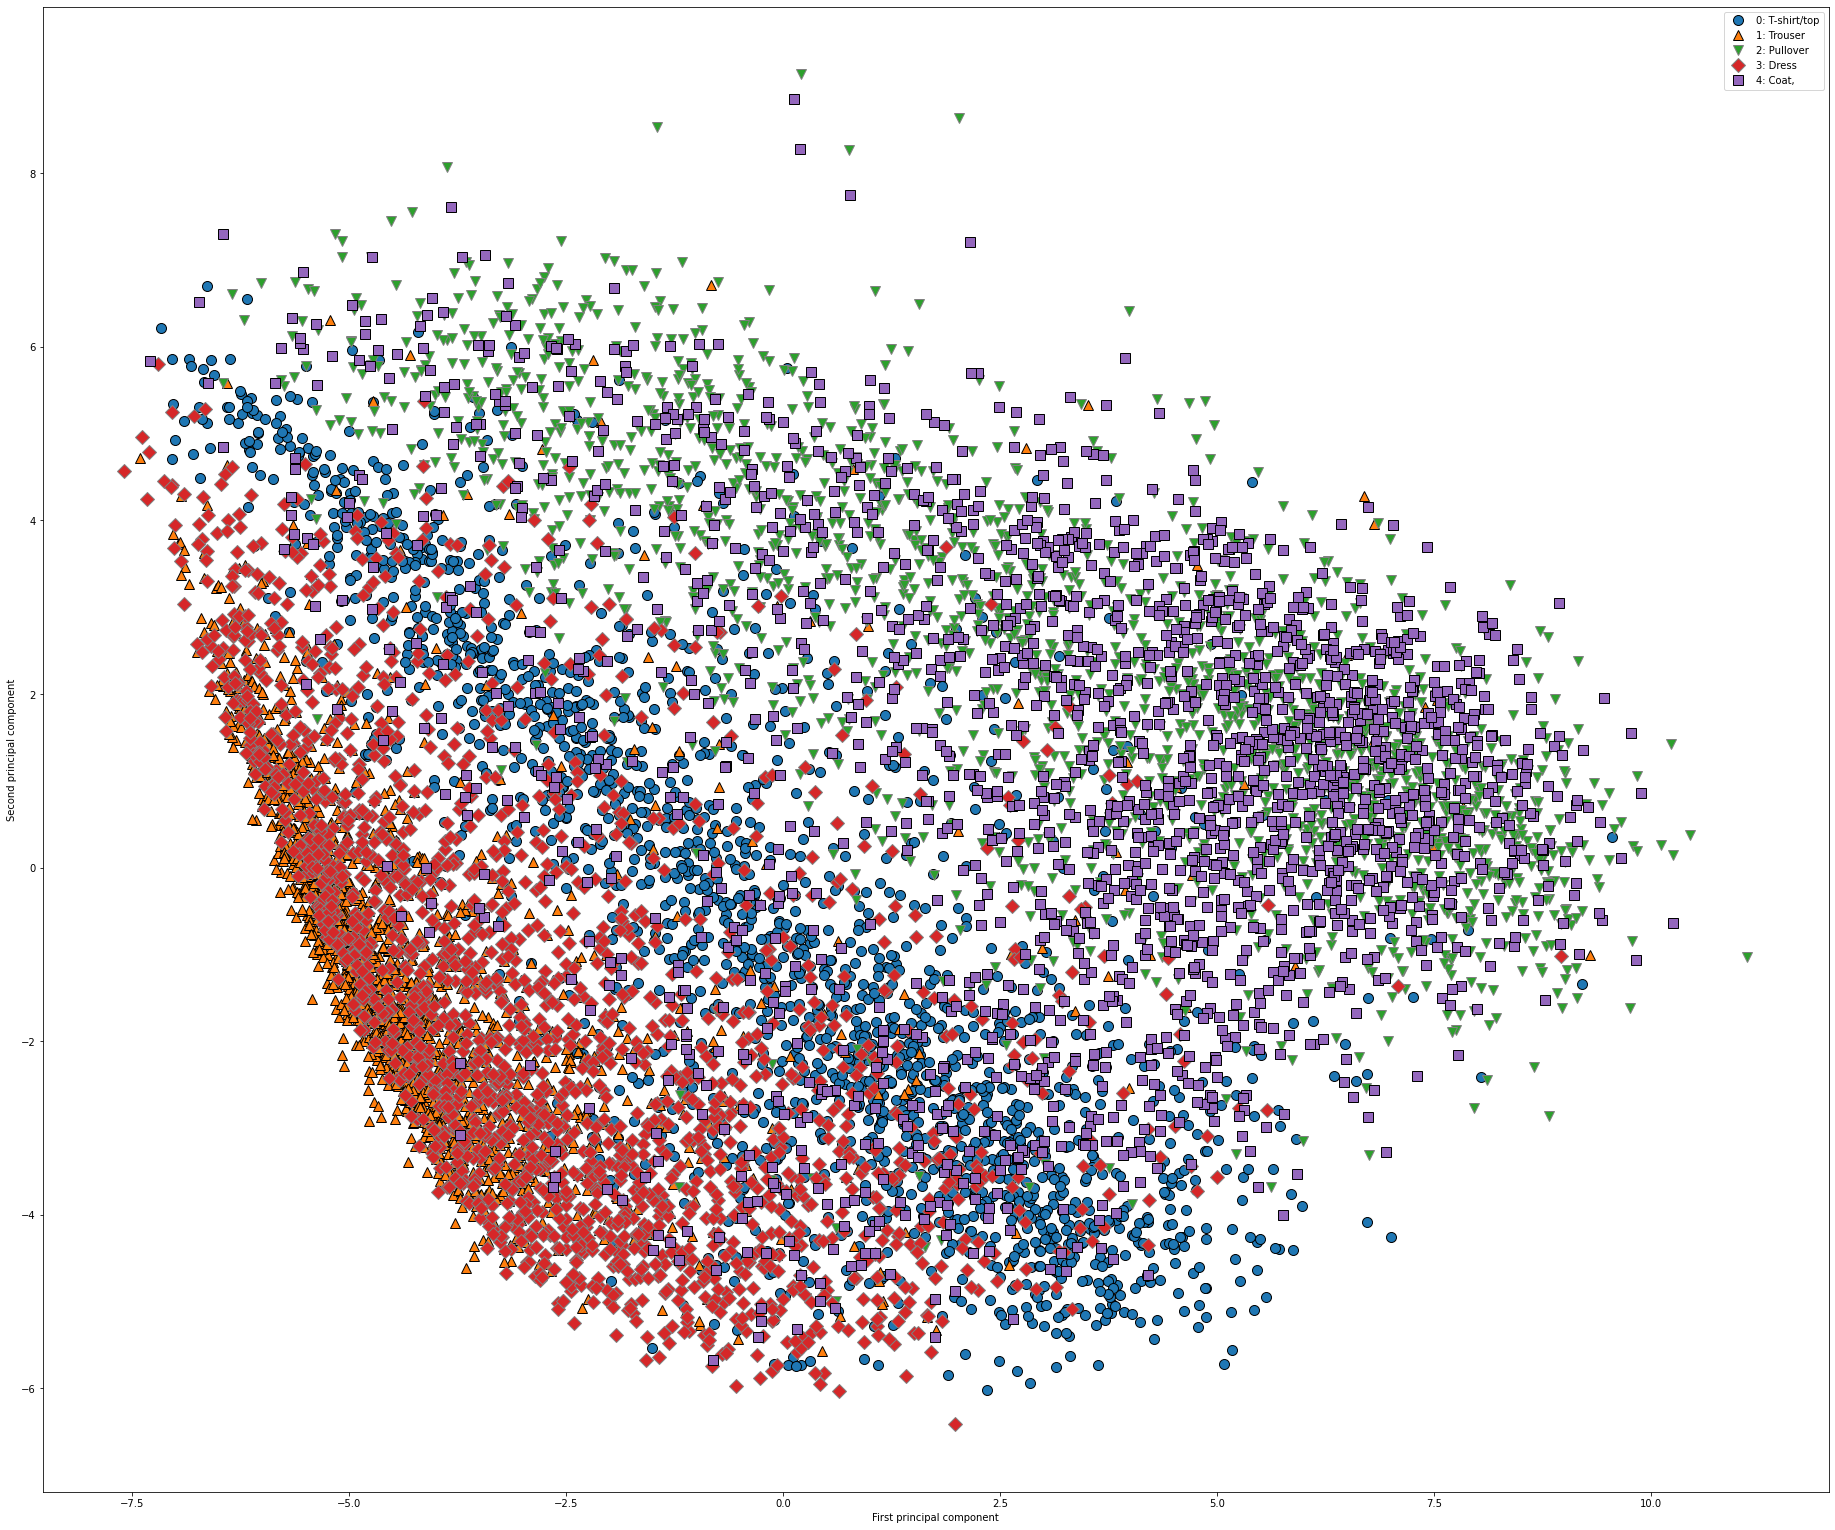

In [212]:
display_preprocessed_2d(preprocess_data(X_train_minmax))

<AxesSubplot:>

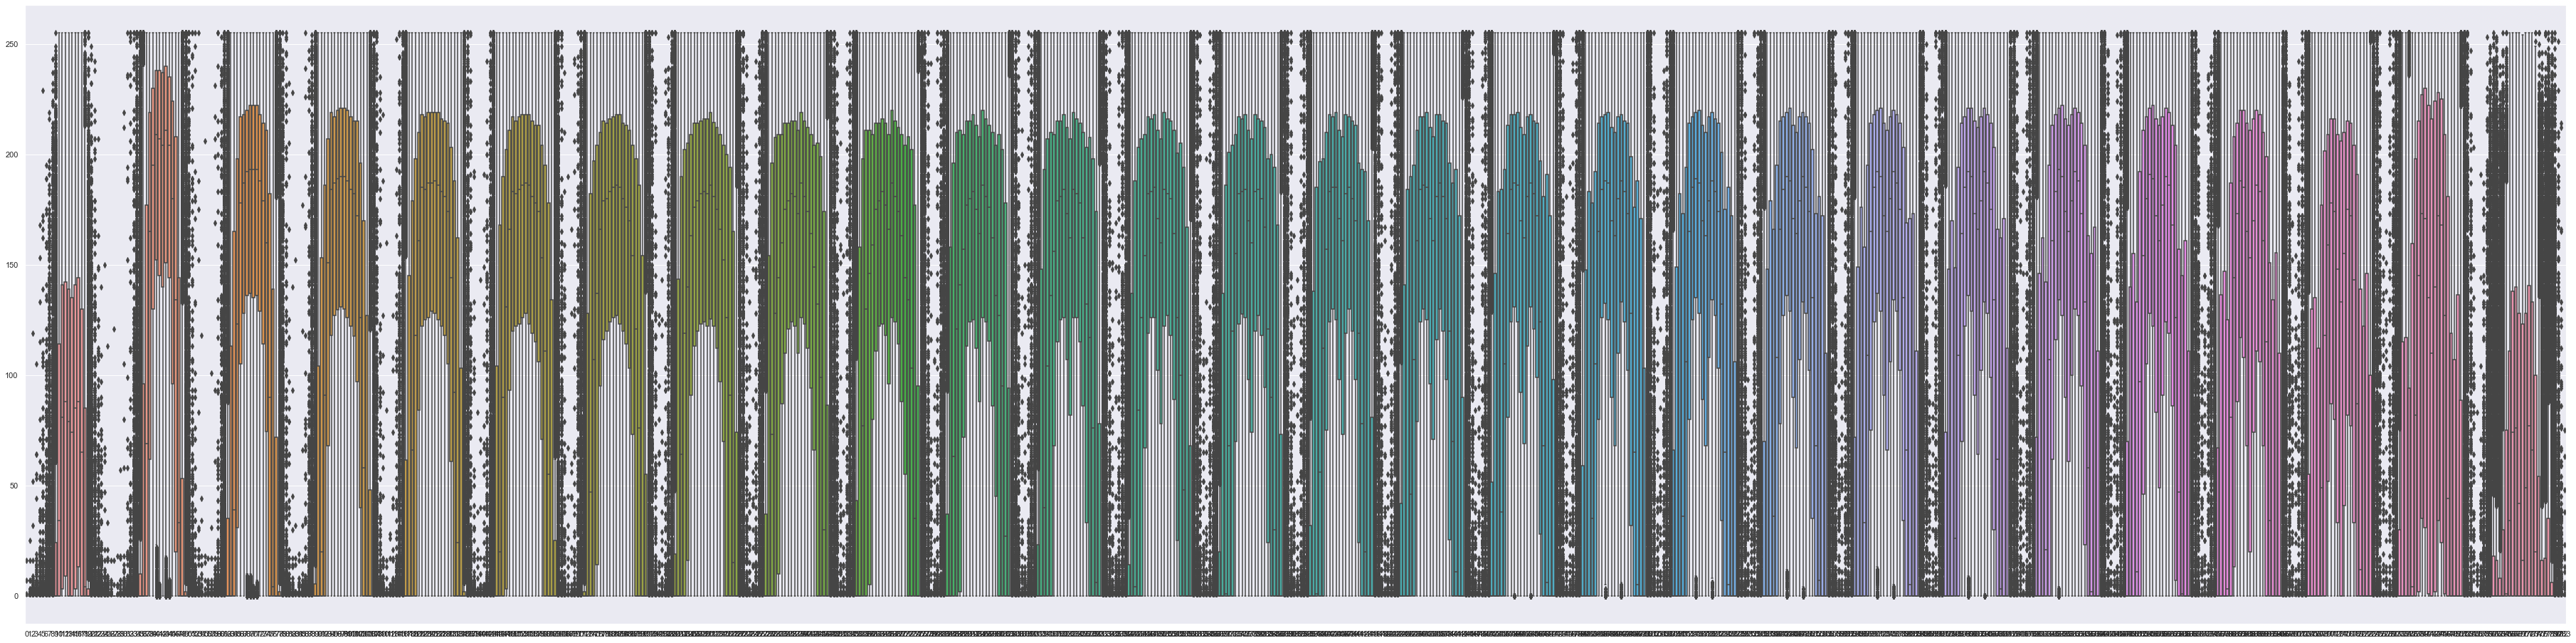

In [236]:
import pandas as pd
import seaborn as sns

columns = np.linspace(0, 32)
features = pd.DataFrame(data=X_train)

# fig, ax = plt.subplots(figsize=(32, 128));
# a = sns.lineplot(ax=ax, x=..., y=...)
sns.set(rc={'figure.figsize': (64, 16)})
sns.boxplot(data=features)
# plt.show()
# features.boxplot()
# sns.boxplot(data=pd.melt(features))
# sns.set(rc={'figure.figsize': (16, 16)})

In [252]:
print(len(X_train[0]))

some_features = np.array(
    X_train[:,
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]]
)
print(len(some_features))
print(len(some_features[0]))
print(some_features)

784
9999
28
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<AxesSubplot:>

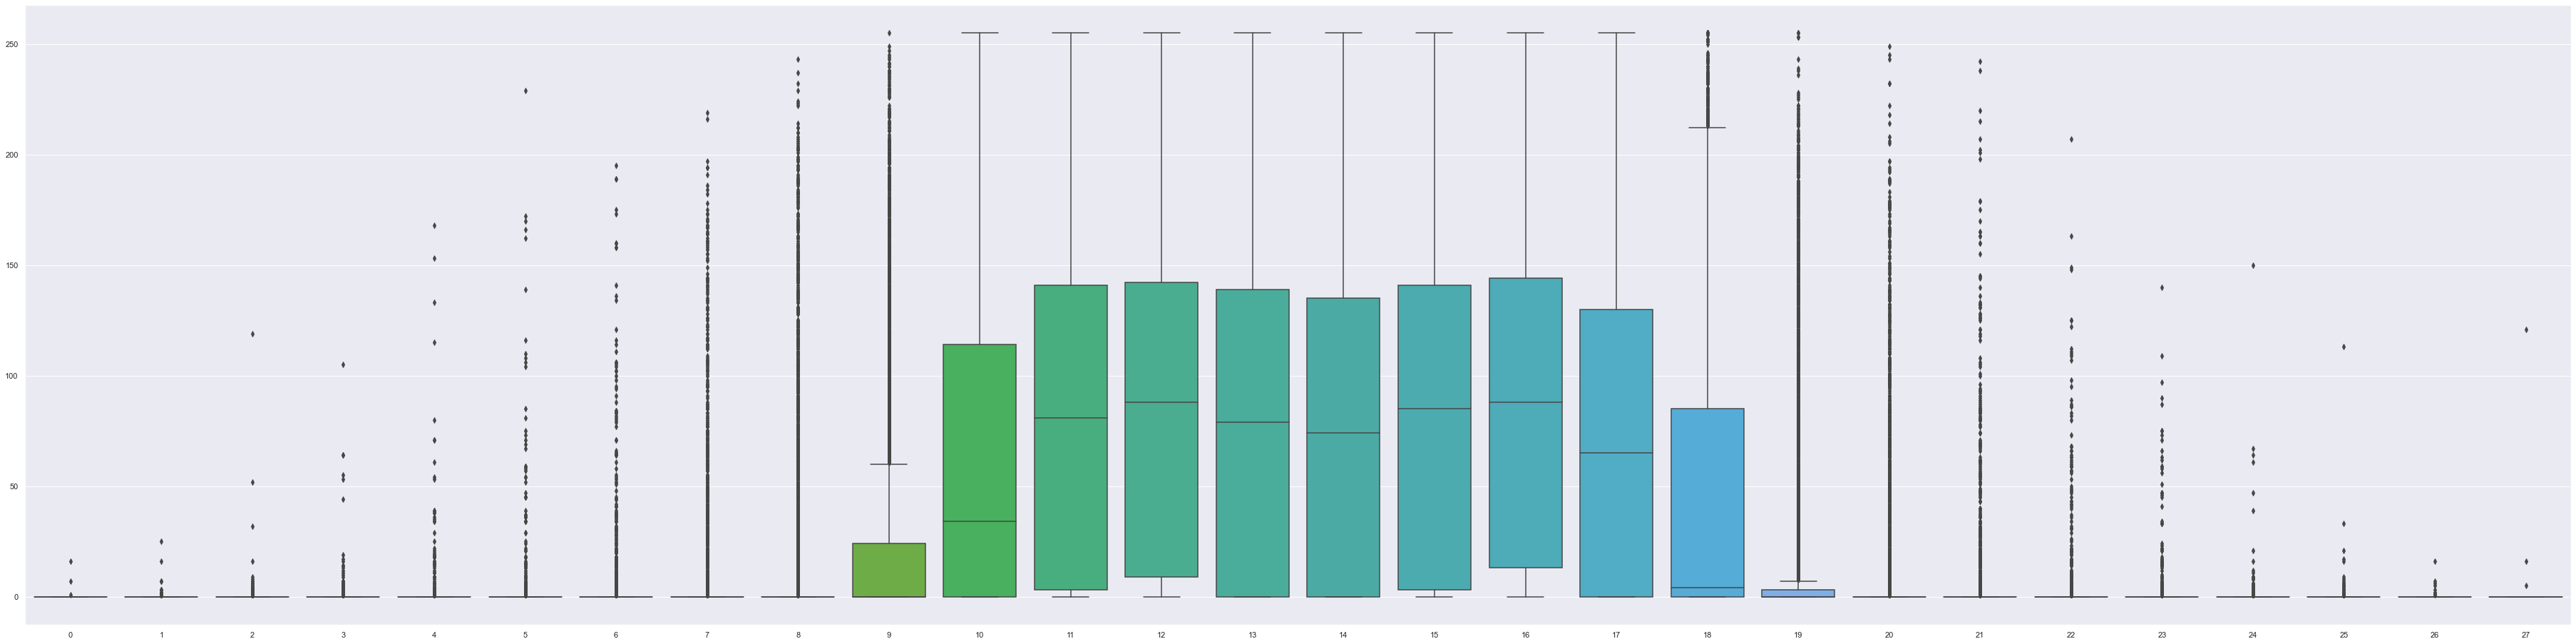

In [253]:
limited_features = pd.DataFrame(data=some_features)

sns.set(rc={'figure.figsize': (64, 16)})
sns.boxplot(data=limited_features)